# Etape 7 — Machine Learning

In [49]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Préparation initiale

In [51]:
df = pd.read_csv('DataFrame_Complet.csv')

In [52]:
ml_df = df.dropna(subset=['CVSS_score', 'Base_severity']).copy()

In [53]:
for col in ['EPSS_score', 'EPSS_percentile']:
    ml_df[col] = ml_df[col].fillna(0)

#### Correction ValueError: The least populated class in y has only 1 member, which is too few

In [55]:
ml_df = ml_df[ml_df['Base_severity'] != 'NONE'].copy()

## Apprentissage supervisé

In [57]:
print("\n--- Début de l'apprentissage supervisé ---")

le = LabelEncoder()
ml_df['Base_severity_encoded'] = le.fit_transform(ml_df['Base_severity'])


--- Début de l'apprentissage supervisé ---


In [58]:
X = ml_df[['CVSS_score', 'EPSS_score', 'EPSS_percentile']]
y = ml_df['Base_severity_encoded']

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
print(f"Taille de l'ensemble d'entraînement : {len(X_train)}")
print(f"Taille de l'ensemble de test : {len(X_test)}")

Taille de l'ensemble d'entraînement : 4419
Taille de l'ensemble de test : 1895


In [60]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [61]:
y_pred = clf.predict(X_test)

In [62]:
# Rapport de classification
unique_labels = np.unique(np.concatenate((y_test, y_pred)))
target_names = le.inverse_transform(unique_labels)
print("\nRapport de classification :")
print(classification_report(y_test, y_pred, target_names=target_names, labels=unique_labels))


Rapport de classification :
              precision    recall  f1-score   support

    CRITICAL       1.00      0.99      1.00       182
        HIGH       1.00      1.00      1.00      1076
         LOW       1.00      1.00      1.00        23
      MEDIUM       1.00      1.00      1.00       614

    accuracy                           1.00      1895
   macro avg       1.00      1.00      1.00      1895
weighted avg       1.00      1.00      1.00      1895



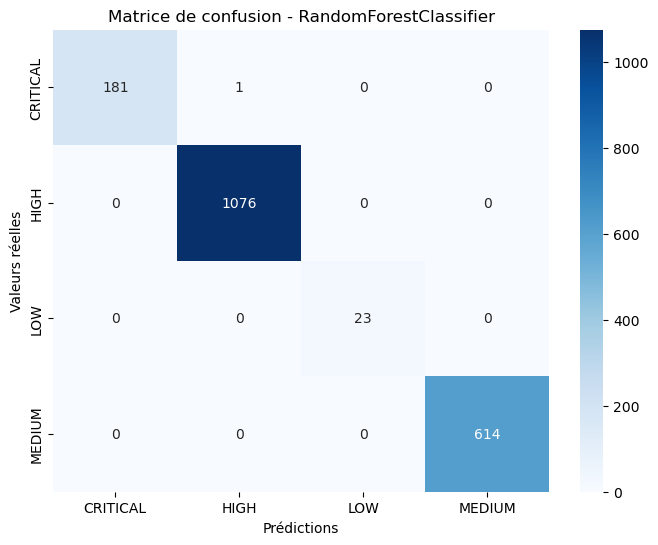

0.9994722955145119

In [96]:
# Matrice de confusion
cm = confusion_matrix(y_test, y_pred, labels=unique_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
plt.title('Matrice de confusion - RandomForestClassifier')
plt.xlabel('Prédictions')
plt.ylabel('Valeurs réelles')
plt.show()

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# View accuracy score
accuracy_score(y_test, y_pred)

#

# Interprétation - Random Forest

- Les valeurs sur la diagonale sont très élevées et les valeurs hors diagonale sont extrêmement faibles (voire nulles). Cela indique que le modèle RandomForestClassifier est exceptionnellement précis pour classer les vulnérabilités dans leurs catégories de gravité respectives (CRITICAL, HIGH, LOW, MEDIUM).
- Il n'y a qu'une seule instance mal classée visible dans cette matrice (un "HIGH" classé comme "CRITICAL").
- La matrice de confusion démontre que le RandomForestClassifier performe de manière exceptionnelle dans la classification des vulnérabilités selon leur gravité (CRITICAL, HIGH, LOW, MEDIUM)
_____
- Le score d'accuracy représente probablement l'exactitude globale du modèle, qui est d'environ 99.95%. C'est un score remarquablement élevé, suggérant que le modèle effectue des prédictions quasi parfaites sur cet ensemble de données.

# Validation du modèle Random Forest

In [116]:
from sklearn.model_selection import cross_val_score

# Pour la classification
scores = cross_val_score(clf, X, y, cv=5, scoring='accuracy')
print(f"Accuracy pour chaque fold : {scores}")
print(f"Accuracy moyenne (Cross-Validation) : {scores.mean():.2f} (+/- {scores.std():.2f})")

Accuracy pour chaque fold : [0.92478226 1.         1.         0.99841647 0.72662441]
Accuracy moyenne (Cross-Validation) : 0.93 (+/- 0.11)


# Interprétation - accuracy Cross val

- Une Accuracy moyenne de 0.93 (93%) est très élevée et indique que, en moyenne, notre modèle Random Forest est capable de faire des prédictions correctes dans 93% des cas sur des données invisibles lors de la validation croisée.

- L'écart type de 0.11 (11%) est relativement élevé, surtout si l'on regarde les scores individuels des folds :
    - Trois folds ont des performances quasi parfaites (1.0, 1.0, 0.998).
    - Un fold est très bon (0.924).
    - Cependant, un fold a une performance significativement plus faible (0.726).
      
- Le fait qu'un des folds ait une accuracy de 0.726 mérite une attention particulière. Cela signifie que pour ce segment spécifique de vos données, le modèle a eu beaucoup plus de mal à faire des prédictions précises.

## Apprentissage non supervisé

In [65]:
print("\n--- Début de l'apprentissage non supervisé ---")

features_for_clustering = ml_df[['CVSS_score', 'EPSS_score', 'EPSS_percentile']]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(features_for_clustering)


--- Début de l'apprentissage non supervisé ---


In [66]:
# Application de K-Means pour trouver 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
ml_df['cluster'] = kmeans.fit_predict(X_scaled)

In [67]:
cluster_centers = scaler.inverse_transform(kmeans.cluster_centers_)
centers_df = pd.DataFrame(cluster_centers, columns=['CVSS_score', 'EPSS_score', 'EPSS_percentile'])
print("\nCaractéristiques moyennes des clusters :")
print(centers_df)


Caractéristiques moyennes des clusters :
   CVSS_score  EPSS_score  EPSS_percentile
0    8.731111    0.621832         0.974871
1    7.899966    0.001377         0.193598
2    5.453697    0.001527         0.214827


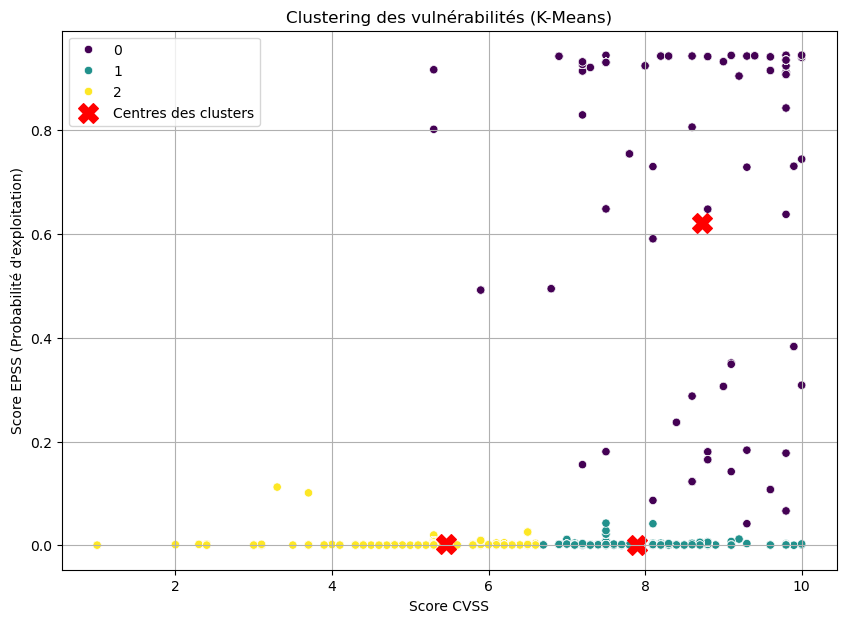


Score Silhouette : 0.554


In [68]:
from sklearn.metrics import silhouette_score

plt.figure(figsize=(10, 7))
sns.scatterplot(data=ml_df, x='CVSS_score', y='EPSS_score', hue='cluster', palette='viridis', legend='full')
plt.scatter(centers_df['CVSS_score'], centers_df['EPSS_score'], s=200, c='red', marker='X', label='Centres des clusters')
plt.title('Clustering des vulnérabilités (K-Means)')
plt.xlabel('Score CVSS')
plt.ylabel('Score EPSS (Probabilité d\'exploitation)')
plt.legend()
plt.grid(True)
plt.show()

# Calculate Silhouette Score
silhouette_avg = silhouette_score(X_scaled, ml_df['cluster'])
print(f"\nScore Silhouette : {silhouette_avg:.3f}")

# Interprétation K-Means clustering

Cela indique que les clusters sont raisonnablement bien séparés et que les points de données au sein de chaque cluster sont relativement cohérents.
Bien que ce score ne soit pas exceptionnellement élevé (un score proche de 0,7 ou 0,8 indiquerait des clusters très forts et distincts), il est nettement supérieur à 0 et loin d'être négatif, ce qui suggère que l'algorithme K-Means a trouvé un partitionnement judicieux de vos données de vulnérabilité.
Ce score concorde avec l'inspection visuelle du graphique, où les clusters, malgré une certaine variation de densité, sont largement distinguables.

Le nuage de points présente les vulnérabilités regroupées en trois groupes (0, 1, 2) selon le score CVSS (axe des abscisses) et le score EPSS (probabilité d'exploitation) (axe des ordonnées). Les marqueurs « X » rouges indiquent les centroïdes des groupes.

- Groupe 0 (points violet foncé/bleus) : Ces vulnérabilités présentent généralement des scores CVSS faibles (de 3 à 6 environ) et des scores EPSS très faibles (généralement proches de 0).
Ce groupe représente les vulnérabilités « à faible risque et faible exploitabilité ». Leur gravité est faible et leur exploitation est très peu probable.
- Groupe 1 (points turquoise/verts) : Ce groupe se caractérise par des scores CVSS élevés (de 6,5 à 10 environ) et des scores EPSS relativement élevés (de 0,5 à 0,9+ environ). Interprétation : Ce groupe représente probablement des vulnérabilités à « risque élevé et exploitabilité élevée ». Il s’agit de problèmes critiques, d’une gravité élevée et d’une probabilité significative d’exploitation.
Ce groupe nécessite généralement une attention immédiate.
- Groupe 2 (points jaunes) : Ces vulnérabilités présentent principalement des scores CVSS élevés (plage similaire à celle du groupe 1, d’environ 7 à 10), mais des scores EPSS très faibles (généralement compris entre 0 et 0,3).
On observe une concentration notable de ces points à des scores EPSS faibles, malgré des scores CVSS plus élevés.
Interprétation : Ce groupe pourrait représenter des vulnérabilités à « risque élevé et exploitabilité faible ». Si leurs scores CVSS indiquent une gravité élevée, leurs faibles scores EPSS suggèrent qu’elles sont moins susceptibles d’être exploitées en pratique.
Cette distinction est très utile, car elle permet de prioriser les vulnérabilités à CVSS élevé à traiter en priorité (celles du groupe 1).

- Séparation et chevauchement des clusters :

Les clusters 0 et 1 semblent relativement bien séparés, notamment sur l'axe des Y (score EPSS).
On observe un chevauchement horizontal du score CVSS entre les clusters 1 et 2, notamment dans la plage CVSS supérieure. Cependant, ils sont clairement séparés par leur score EPSS, qui constitue ici le principal facteur de différenciation.
Cela indique que le clustering exploite efficacement les deux dimensions pour créer des groupes significatifs.
Les centroïdes sont situés de manière appropriée au sein de leurs clusters respectifs.

2. Pour notre K-means, nous avons obtenu un score silhouette de 0,554. Un score de 0,554 est généralement considéré comme un résultat de clustering modérément bon. Il indique que les clusters sont raisonnablement bien séparés et que les points de données au sein de chaque cluster sont relativement cohérents.
Bien que ce score ne soit pas exceptionnellement élevé, il est nettement supérieur à 0 et loin d'être négatif, ce qui suggère que l'algorithme K-means a trouvé un partitionnement judicieux de vos données de vulnérabilité.
Ce score concorde avec l'inspection visuelle du graphique, où les clusters, malgré une certaine variation de densité, sont largement distinguables.

Conclusion :
Notre clustering K-Means, composé de trois clusters, a permis de segmenter les vulnérabilités en groupes distincts et interprétables en fonction de leurs scores CVSS et EPSS.

Nous avons identifié au moins trois profils :
Faible risque/Faible exploitabilité (Cluster 0)
Risque élevé/Forte exploitabilité (Cluster 1)
Risque élevé/Faible exploitabilité (Cluster 2)
Le score Silhouette de 0,536 confirme la validité de ces clusters, indiquant un bon niveau de séparation et de cohésion.

# Validation du modèle K-means

In [ ]:
# Méthode du coude (Elbow Method)
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import pandas as pd # Supposons que df est votre DataFrame de données

wcss = []
for i in range(1, 11): # Tester k de 1 à 10
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_) # inertia_ est le WCSS

plt.plot(range(1, 11), wcss)
plt.title('Méthode du coude')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('WCSS')
plt.show()

# Interprétation - Elbow Method

Sur le graphique Elbow Method, le coude semble se situer autour de K=3. Cela confirme le clustering des vulnérabilités précédents, avec 3 clusters.

Pour k=2, le score de silhouette est : 0.62
Pour k=3, le score de silhouette est : 0.57
Pour k=4, le score de silhouette est : 0.58
Pour k=5, le score de silhouette est : 0.56
Pour k=6, le score de silhouette est : 0.62
Pour k=7, le score de silhouette est : 0.62
Pour k=8, le score de silhouette est : 0.63
Pour k=9, le score de silhouette est : 0.63
Pour k=10, le score de silhouette est : 0.63


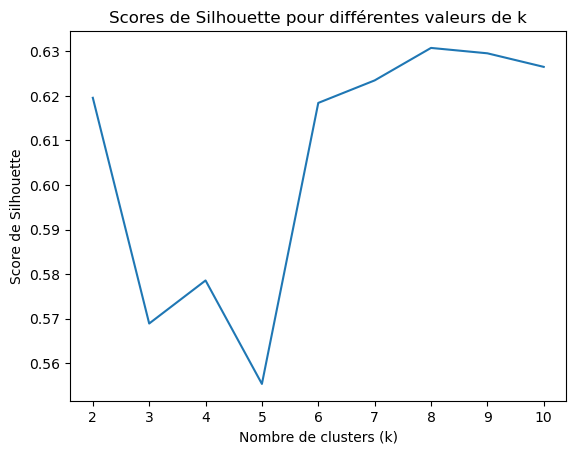

In [122]:
# Scores de Silhouette
silhouette_scores = []
for i in range(2, 11): # Le score de silhouette n'est pas défini pour k=1
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    cluster_labels = kmeans.fit_predict(X)
    score = silhouette_score(X, cluster_labels)
    silhouette_scores.append(score)
    print(f"Pour k={i}, le score de silhouette est : {score:.2f}")

plt.plot(range(2, 11), silhouette_scores)
plt.title('Scores de Silhouette pour différentes valeurs de k')
plt.xlabel('Nombre de clusters (k)')
plt.ylabel('Score de Silhouette')
plt.show()

# Interprétation - Scores de silhouette

Le score de silhouette est relativement bas pour k=2, puis augmente de manière significative pour k=3, atteignant son point le plus élevé. Après k=3, le score de silhouette semble diminuer ou stagner, ce qui suggère que l'ajout de clusters supplémentaires au-delà de 3 ne mejora pas nécessairement la qualité du clustering en termes de séparation et de cohésion. Cela correspond à K=3 du graphe de clusterings de vulnérabilités K-Means.